In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.porter import *

In [10]:
data = pd.read_csv('data/train.csv')
data.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


In [11]:
data.shape

(7274, 3)

In [12]:
data.isnull().sum()

tweet_id     0
tweet        1
sentiment    0
dtype: int64

In [13]:
data.dropna(inplace=True)

In [14]:
data.shape

(7273, 3)

In [15]:
# function to remove user handles
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)

    return input_txt 

In [16]:
data['tweet_len_noisy'] = [len(t) for t in data.tweet]

In [17]:
data.head()

,tweet_id,tweet,sentiment,tweet_len_noisy
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,89
1,1851,Learning ab Google doodles! All doodles should...,1,143
2,2689,one of the most in-your-face ex. of stealing t...,2,132
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,125
4,3604,Line outside the Apple store in Austin waiting...,1,77


In [18]:
data['tweet'] = data['tweet'].str.lower()

In [19]:
data.head()

,tweet_id,tweet,sentiment,tweet_len_noisy
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,89
1,1851,learning ab google doodles! all doodles should...,1,143
2,2689,one of the most in-your-face ex. of stealing t...,2,132
3,4525,this iphone #sxsw app would b pretty awesome i...,0,125
4,3604,line outside the apple store in austin waiting...,1,77


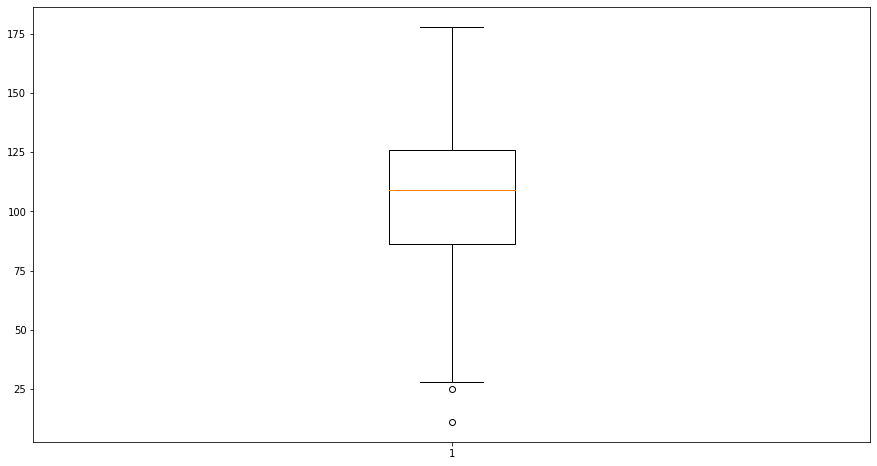

In [20]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.boxplot(data.tweet_len_noisy)
plt.show()

### Twitter's character limit was recently changed to 280. So the length of the tweets are well within the range.

In [21]:
data['tweet'][54]

'&lt;just a rumor...&gt; rt @mention google to launch major new social network called circles, possibly today {link} #sxsw'

### In the above tweet there are characters &lt; which means "less than" , hence the above tweet should be read as

### "< just a rumour > ... "

In [22]:
#trying out the library
example1 = BeautifulSoup(data['tweet'][54], 'lxml').get_text()
print(example1)

<just a rumor...> rt @mention google to launch major new social network called circles, possibly today {link} #sxsw


In [23]:
#using the library on the dataframe
data['tweet'] = data['tweet'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

In [24]:
data['tweet'][54]

'<just a rumor...> rt @mention google to launch major new social network called circles, possibly today {link} #sxsw'

### We have successfully converted html encoded characters to text. This makes it easier for us to process the text further as we have to remove punctuations.

In [25]:
data['tweet'][10]

'rt @mention official #sxsw app \x89û÷sxsw go\x89ûª bit.ly/hmiiga #android #iphone #ipad'

In [26]:
#removing user handles
data['tweet'] = data['tweet'].apply(lambda row:remove_pattern(row, "@[\w]*"))

In [27]:
data['tweet'][10]

'rt  official #sxsw app \x89û÷sxsw go\x89ûª bit.ly/hmiiga #android #iphone #ipad'

In [28]:
data['tweet'][2967]

'retrollect is now also in android market! #sxsw https://market.android.com/details?id=com.borderstylo.retrollect'

In [29]:
data.to_csv('data/new_train.csv', index=False)

### We can see there are URLs which needs to be treated.

In [30]:
def identify_urls(tweet):
    """
    This is a function that will search for URLs withing a string. It returns the URL part if there is any or it will
    return 'No URL'
    """
    
    regex = r'('

    # Scheme (HTTP, HTTPS, FTP and SFTP):
    regex += r'(?:(https?|s?ftp):\/\/)?'

    # www:
    regex += r'(?:www\.)?'

    regex += r'('

    # Host and domain (including ccSLD):
    regex += r'(?:(?:[A-Z0-9][A-Z0-9-]{0,61}[A-Z0-9]\.)+)'

    # TLD:
    regex += r'([A-Z]{2,6})'

    # IP Address:
    regex += r'|(?:\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})'

    regex += r')'

    # Port:
    regex += r'(?::(\d{1,5}))?'

    # Query path:
    regex += r'(?:(\/\S+)*)'

    regex += r')'
    
    #searching for URLs in the tweet
    find_urls_in_string = re.compile(regex, re.IGNORECASE)
    url = find_urls_in_string.search(tweet)
    
    if url is not None and url.group(0) is not None:
        return url.group(0).strip()
    else:
        return "No URL"

In [31]:
data['URL'] = data['tweet'].apply(lambda x: identify_urls(x))

In [32]:
data['URL'].value_counts()

No URL                                                                                         7142
webdoc.com                                                                                        8
bit.ly/g03mzb                                                                                     8
actsofsharing.com                                                                                 5
rww.to/f6bcet                                                                                     5
mint.com                                                                                          4
https://www.facebook.com/event.php?eid=141164002609303                                            2
theatlantic.com/technology/archive/2011/03/apple-sets-up-temporary-megastore-at-sxsw/72296/       2
lightbox.com                                                                                      2
internetonlinewebsite.com                                                                         2


### Thus we have successfully added the URL part into a new column so that they can be processed separately. We also need to remove the URL part from the string.

In [33]:
data['tweet']  = data['tweet'].replace(r'http\S+', '', regex=True).replace(r'https\S+', '', regex=True).replace(r'www\S+', '', regex=True)

In [34]:
data['tweet'][2967]

'retrollect is now also in android market! #sxsw '

In [35]:
data['tweet']  = data['tweet'].apply(lambda x: re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', x))

In [36]:
data['tweet'][2967]

'retrollect is now also in android market! #sxsw '

In [37]:
stop_words = list(set(stopwords.words('english')))+list(punctuation)+['``', "'s", "...", "n't"]

In [38]:
data['tweet'][87]

"rt  any ipad2's left at the apple store at #sxsw? anyone know? :)"

### We can see there are emojis which needs to be converted to the text they represent

In [39]:
def handle_emojis(tweet):
    """
    In this method we are converting the emojis with the text they represent. 
    Happy emojis are converted to EMO_POS and negative to EMO_NEG.
    """
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' smiling ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' laughing ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' love ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' wink ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' sad ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' cry ', tweet)
    
    return tweet

In [40]:
data['tweet'] = data['tweet'].apply(lambda x: handle_emojis(x))

In [41]:
data['tweet'][87]

"rt  any ipad2's left at the apple store at #sxsw? anyone know?  smiling "

In [42]:
data['tweet'][1251]

' gr8 meeting u irl after the book signing today! really enjoyed your ipad prez & mahalo for the autograph! #sxsw #hisxsw'

### We can see there are shortforms such as Gr8 which needs to be converted to their full forms.

In [43]:
#converting to full meaningful words
short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"ab": "about",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"mkt": "market",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"yrs": "years",
"ym": "young man",
"gr8": "great"
}

In [44]:
def dict_words(text, dictionary):
    """
    Method to replace a word with a word from the dictionary.
    The dictionary will have the word to be replaced as key and the new word as value
    """
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
                print("Old: "+word)
                print("New: "+text)
    return text

In [45]:
text = "gr8 meeting u irl after the book signing today! really enjoyed your ipad prez & mahalo for the autograph! #sxsw #hisxsw"

newtext = dict_words(text, short_word_dict)
print("New text: " + newtext)

Old: gr8
New: great meeting u irl after the book signing today! really enjoyed your ipad prez & mahalo for the autograph! #sxsw #hisxsw
Old: u
New: great meeting you irl after the book signing today! really enjoyed yoyour ipad prez & mahalo for the ayoutograph! #sxsw #hisxsw
Old: irl
New: great meeting you in real life after the book signing today! really enjoyed yoyour ipad prez & mahalo for the ayoutograph! #sxsw #hisxsw
New text: great meeting you in real life after the book signing today! really enjoyed yoyour ipad prez & mahalo for the ayoutograph! #sxsw #hisxsw


In [46]:
data['tweet'] = data['tweet'].replace('[...…]','').str.split().apply(lambda x: ' '.join([short_word_dict.get(e, e) for e in x]))

In [47]:
data['tweet'][1251]

'great meeting you in real life after the book signing today! really enjoyed your ipad prez & mahalo for the autograph! #sxsw #hisxsw'

In [48]:
data['tweet'][2121]

"why should/shouldn't i get an ipad 2? discuss smiling #sxsw"

In [115]:
#pre-precessing function
def preprocess_text(data, col_name):
    
    #converting string to lower case
    data[col_name] = data[col_name].str.lower()
    
    #remove user handles
    data[col_name] = data[col_name].apply(lambda row:remove_pattern(row, "@[\w]*"))
    
    #converting html characters to strings
    data[col_name] = data[col_name].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())
    
    #converting emojis to the string they represent
    data[col_name] = data[col_name].apply(lambda x: handle_emojis(x))
    
    #removing URLs from the tweets
    data[col_name]  = data[col_name].apply(lambda x: re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', x))
    
    #converting abbreviations to their full forms
    data[col_name] = data[col_name].replace('[...…]','').str.split().apply(lambda x: ' '.join([short_word_dict.get(e, e) for e in x]))
    
    # Remove single space remaining at the front of the tweet.
    data[col_name] = data[col_name].apply(lambda x: x.lstrip(' '))
    
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    data[col_name] = data[col_name].apply(lambda x: ''.join(c for c in x if c <= '\uFFFF'))
    
    #removing non-ASCII characters
    data[col_name] = data[col_name].apply(lambda x: ''.join([i if ord(i) < 128 else ' ' for i in x]))
    
    # Remove words with 2 or fewer letters
    data[col_name] = data[col_name].apply(lambda x: re.sub(r'\b\w{1,2}\b', '', x))
    
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    data[col_name] = data[col_name].apply(lambda x: re.sub(r'(.)\1+', r'\1\1', x))
    
    #tokenizing data
    data[col_name] = data[col_name].apply(lambda x: nltk.word_tokenize(x))
    
    #stopwords removal
    stop_words = list(set(stopwords.words('english')))+list(punctuation)+['``', "'s", "...", "n't", "'re", "''"]
    data[col_name] = data[col_name].apply(lambda row: [word for word in row if word not in stop_words])
    
#     # stemming words
#     stemmer = PorterStemmer()
#     data[col_name] = data[col_name].apply(lambda x: [stemmer.stem(i) for i in x])
    data[col_name] = data[col_name].apply(lambda x: ' '.join(x))
    
    return data

In [116]:
raw_data = pd.read_csv('data/train.csv')
raw_data.dropna(inplace=True)

In [117]:
processed_data = preprocess_text(raw_data, 'tweet')

In [118]:
processed_data.to_csv('data/processed_data.csv', index=False)

In [119]:
processed_data.head(20)

,tweet_id,tweet,sentiment
0,1701,sxswnui sxsw apple defining language touch dif...,1
1,1851,learning google doodles doodles light funny in...,1
2,2689,one -your-face stealing show years sxsw apple ...,2
3,4525,iphone sxsw app would pretty awesome crash eve...,0
4,3604,line outside apple store austin waiting new ip...,1
5,966,technews one lone dude awaits ipad apple sxsw ...,1
6,1395,sxsw tips prince npr videos toy shopping zucke...,1
7,8182,user new ubersocial iphone app store includes ...,1
8,8835,free sxsw sampler itunes link freemusic,2
9,883,think might weekend without seeing ipad case t...,2


In [122]:
test_data = pd.read_csv('data/test.csv')
test_data.head()

,tweet_id,tweet
0,7506,Audience Q: What prototyping tools do you use?...
1,7992,At SXSW? Send Your Best Photos &amp; Videos to...
2,247,@mention and here's a pic of you winning your...
3,7688,Google Marissa Mayer: mobile phone as a cursor...
4,3294,#SXSW Google maps is even cooler than I thought
